# 09 - 非服从性与局部平均效应

## 让我们逐渐踏入一个异构的世界

之前，我们已经通过更传统的视角学习了工具变量。 工具变量（IV）被视为某种我们可以利用的自然实验。相比之下，现代视角下的 IV 实践从医学科学中汲取了很多见解。它将世界划分为 4 种主体，这取决于它们对工具变量的反应。

1. 依从者
2. 从不接受者
3. 永远的接受者
4. 违抗者（defiers）

这个命名来自药学。想象一下，您正在进行一项实验，以测试一种新药对某些疾病的影响。每个受试者被分配到一种治疗：药物或安慰剂。服从者是那些无论分给他们什么，他们都100%接纳的人群。如果他们得到安慰剂，他们就会服用；如果他们得到药物，他们也会服用。从不接受者是那些拒绝服药的受试者。即使他们被分配了新药，他们也不会服用。另一方面，总是服用者是那些即使分配给安慰剂也能以某种方式获得新药的人。最后，违抗者是那些在分配到控制组时却要求接受治疗的人，如果分配给了治疗组则要接受安慰剂的人。你可以把他们想象成那个做事与所说相反的烦人的孩子。在实践中，它们并不常见（我指的是属于违抗者的受试人员，而不是小孩），所以我们经常会忽略它们。

![img](./data/img/late/defiers.png)

现代 IV 将该工具变量视为一种准实验设计，其中服从性并不完美。通过这样做，它可以将内部有效的因果效应与外部有效的因果效应区分开来。提醒一下，内部有效的影响是我们能够识别的。它在该特定设置中有效，具有该特定数据。在IV中，将是工具变量改变干预的那些干预效果。另一方面，外部效度与因果效应的预测能力有关。它会问我们是否可以将我们在这个样本中发现的影响推广到其他人群的问题。例如，假设您在大学进行了一项随机对照试验，以确定人们在给予捐赠激励时是否慷慨。实验设计得很好，但你只邀请经济学学生参加。然后你会发现他们都是自私的混蛋。这是一个内部有效的结论。它对那些数据点有效。但是你能从那个实验中推断出人类是自私的吗？事实并非如此。因此，我们会质疑您的实验是否具有概括其结果的外部有效性。无论如何，回到IV。

为了更具体，让我们考虑一个案例，您希望通过应用内购买来提高用户参与度。一种方法是要求您的营销部门提出可以用来吸引用户的推送。他们提出了出色的设计和非常花哨的用户交互。在这种推动下，您继续设计随机试验。您选择 10000 个随机客户，并为每个客户分配 50% 的概率推送。但是，当您执行测试时，您会注意到一些被分配接收推送的客户没有收到推送。当您与工程师交谈时，他们说那是因为他们可能拥有不支持营销团队设计的那种推送的旧手机。

起初，您可能认为这没什么大不了的。您可以只使用接受的干预，而不是使用分配为干预变量的干预，对吗？事实证明，事情并没有那么简单。如果你绘制整个情况的因果图，它看起来像这样：

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
from linearmodels.iv import IV2SLS
import graphviz as gr

%matplotlib inline

style.use("fivethirtyeight")

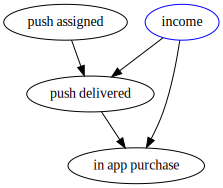

In [2]:
g = gr.Digraph()

g.edge("push assigned", "push delivered")
g.edge("push delivered", "in app purchase")
g.edge("income", "in app purchase")
g.edge("income", "push delivered")
g.node("income", color="blue")
g

在因果图上，您有推送分配。这是设计随机的，因此没有任何原因。然后，如果推送已交付，您就有了一个节点。不是每个被分配接收推送的人都这样做了，所以你在这里不合规。更具体地说，你有一些从不接受者：那些即使被分配到实验组也不会接受干预的人。您也有理由怀疑这种不合规性并非偶然。由于使用旧手机的人不会获得推送，因此您可以争辩说收入也导致推送交付。越富有的人越有可能拥有更好的手机，这反过来又使他或她更有可能收到推送。最后，你有结果变量，在应用程序购买。请记住，我们不知道收入，因此我们无法控制它。考虑到这一点，让我们来看看如果我们简单地使用分配作为处理变量的推送，而不是我们使用推送交付作为处理会发生什么。

在第一种情况下，我们将通过以下均值差异来估计因果效应：


$
ATE = E[Y | pushAssigned=1] - E[Y |推送分配=0]
$

正如我们现在非常清楚的那样，这只是 \\(E[Y_1] - E[Y_0]\\) 的无偏估计，如果偏差 \\(E[Y_0|推送分配=0] - E[Y_0|推送分配= 1]\\) 为零。由于`pushAssigned` 是随机的，我们知道偏差为零。这样就解决了吗？不完全的。你看，如果我们这样做，我们实际上是在回答一个与我们打算回答的问题不同的问题。我们将找到**干预分配的因果效应**，而不是干预本身。但是它们是不同的还是我们可以将干预分配的因果效应外推到 ATE？换句话说，干预分配的因果效应是对 ATE 的无偏估计吗？

事实证明，事实并非如此。由于不依从，分配给干预的人的结果将朝着分配给控制的人的结果的方向推动。不依从会无意中翻转干预，使干预组和控制组在结果上更加相似。不要将此与变量的相似性混淆。我们希望干预组和控制组在构成变量上相似。这将使它们具有可比性。如果确实有干预效果，我们不希望它们的结果相似。

要看到这一点，首先假设我们总是接受者。他们中的一些人会偶然被分配到控制权。但那些是，无论如何都会接受干预。这使得它们本质上是一个与对照混合的处理组。作为这种混合的结果，当我们不遵守规定时，将更难找到因果关系。

![img](./data/img/late/always_takers.png)

同理，永不接受者会让那些被分配到干预的人看起来有点像未经干预的人，因为即使被分配到干预，他们也不会接受干预。从这个意义上说，**干预分配的因果效应偏向于零**，因为不遵守会缩小可检测的影响。看待这一点的另一种方式是想象一个极端情况。假设不服从比率非常高。干预分配没有说明接受的干预。在这种情况下，接受的干预完全是随机的。在 IV 语言中，这意味着我们的第一阶段非常薄弱。使用 `Z` 来表示处理分配，我们会得到

$
E[Y|Z=1] - E[Y|Z=0] = 0
$

干预分配与结果之间不再存在因果关系。 Z 将只是一个无意义的随机变量漂浮在那里。

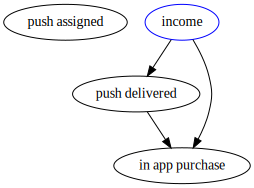

In [3]:
g = gr.Digraph()

g.node("push assigned")
g.edge("push delivered", "in app purchase")
g.edge("income", "in app purchase")
g.edge("income", "push delivered")
g.node("income", color="blue")
g

好的，所以我们已经排除了使用分配的因果效应作为估计干预因果效应的方法。那么，仅使用接受的干预样本怎么样？

$
ATE = E[Y | push=1] - E[Y |推=0]
$

我们依旧需要考虑这是否有偏差，即 \\(E[Y_0|push=0] = E[Y_0|push=1]\\)。仅通过查看上面的因果图，我们就知道情况并非如此。我们有无法衡量的混淆因素：收入，潜伏着，它肯定会把事情搞砸。正如我们之前所说，我们知道推送交付失败，在我们的案例中，是由客户使用旧手机造成的。这意味着我们可能有 \\(E[Y_0|push=0] < E[Y_0|push=1]\\)。我们认为这是因为资金较少的客户都拥有旧手机，这将导致 \\(push=0\\) 以及应用购买潜力较低 \\(Y_0\\)。

真是没想到啊！我们不能使用分配的干预或接受的干预来直接估计我们的 ATE。但幸运的是，我们知道我们可以使用什么：工具变量。在这里，指定好的干预是干预变量本身对应的完美工具变量。它和随机分配一样好，它只是通过干预导致应用内购买。

## 局部平均干预效果：后期

局部平均处理效应明确了我们可以估计因果效应的人群。这也是查看 IV 的另一种方式，它提供了我们可以使用的其他很酷的直觉。在现代 IV 中，我们将工具视为启动因果链：Z 导致 T 导致 Y。在这种情况下，排除限制意味着 Z 不会导致 Y，除非通过其对 T 的影响。现在将第一阶段视为Z 对 T 的因果效应。我们还用双索引符号重写潜在结果，其中第一个索引表示工具的反事实，第二个索引表示处理

$
\text{潜在结果}=\begin{cases}
Y_i(1, 1) \ \text{if } T_i=1, \ Z_i=1\\
Y_i(1, 0) \ \text{if } T_i=1, \ Z_i=0\\
Y_i(0, 1) \ \text{if } T_i=0, \ Z_i=1\\
Y_i(0, 0) \ \text{if } T_i=0, \ Z_i=0\\
\end{cases}
$

从某种意义上说，干预成为结果，至少在第一阶段是这样。这意味着我们也可以用潜在的结果符号来写它：

$
\text{潜在干预}=\begin{cases}
T_0 \ \text{if } Z_i=0 \\
T_1 \ \text{if } Z_i=1
\end{cases}
$

![img](./data/img/late/double_index.png)

工具变量假设现在可以重写如下

1. \\(T_{0i}, T_{1i} \perp Z_i \\) 和 \\(Y_i(T_{1i},1), Y_i(T_{0i},0) \perp Z_i \\)。这就是独立性假设。这表示该仪器与随机分配的一样好。换句话说，工具变量 Z 与潜在干预无关，这与说不同工具变量组的人具有可比性是相同的。

2. \\(Y_i(1, 0)=Y_i(1, 1)=Y_{i1}\\) 和 \\(Y_i(1, 0)=Y_i(1, 1)=Y_{i0}\\ ）。这是排除限制。它说，如果我正在考虑接受干预的潜在结果，那么两个工具变量组的结果都是一样的。换句话说，该工具变量不影响潜在结果，这与说该工具变量仅通过干预影响结果相同。

3. \\(E[T_{1i}-T_{0i}] \neq 0\\)。这是第一阶段的存在。据说第一阶段的潜在结果，即潜在的干预，是不一样的。另一种说法是工具变量确实会影响干预。

4. \\(T_{i1} > T_{i0}\\)。这就是单调性假设。据说如果每个人都打开工具变量，干预水平会高于每个人都关闭干预的水平。

现在，让我们回顾一下 Wald 估计量，以进一步了解 IV：

$
ATE = \dfrac{E[Y|Z=1]-E[Y|Z=0]}{E[T|Z=1]-E[T|Z=0]}
$

让我们取它的第一位，\\(E[Y|Z=1]\\)。使用排除限制，我们可以根据这样的潜在结果重写 Y。

$
E[Y_i|Z_i=1]=E[Y_{i0} + T_{i1}(Y_{i1} - Y_{i0})|Z=1]
$

使用独立性，我们可以去掉 Z 上的条件。

$
E[Y_i|Z_i=1]=E[Y_{i0} + T_{i1}(Y_{i1} - Y_{i0})]
$

用类似的论证，我们得到

$
E[Y_i|Z_i=0]=E[Y_{i0} + T_{i0}(Y_{i1} - Y_{i0})]
$

我们现在可以像这样重写 Wald 估计量的分子

$
E[Y|Z=1]-E[Y|Z=0] = E[(Y_{i1}-Y_{i0})(T_{i1}-T_{i0})]
$

使用单调性，我们知道 \\(T_{i1}-T_{i0}\\) 是 0 或 1，所以

$
E[(Y_{i1}-Y_{i0})(T_{i1}-T_{i0})] = E[(Y_{i1}-Y_{i0})|T_{i1}>T_{i0}] P(T_{i1}>T_{i0})
$

使用类似的论点来解决分母，我们得到

$
E[T|Z=1]-E[T|Z=0]=E[T_{i1}-T_{i0}]=P(T_{i1}>T_{i0})
$

所有这一切让我们可以这样看待 Wald 估计量：

$
ATE = \dfrac{E[(Y_{i1}-Y_{i0})|T_{i1}>T_{i0}]P(T_{i1}>T_{i0})}{P(T_{i1}> T_{i0})}=E[(Y_{i1}-Y_{i0})|T_{i1}>T_{i0}]
$
也就是说，由 IV 估计的 ATE 是子群上的 ATE，其中 \\(T_{i1}>T_{i0}\\)。如果您考虑合规性，这是哪个人群？这是那些工具变量影响通道打开后干预水平高于关闭工具变量影响通道的人群。换句话说，这是服从人群。我们可以记住如下几类，

1. 服从者意味着 \\(T_{i1}>T_{i0}\\)
2. 永不接受者意味着 \\(T_{i1}=T_{i0}=0\\)
3. 总是接受者意味着 \\(T_{i1}=T_{i0}=1\\)

结论是，IV 没有说明对永不接受者、总是接受者或拒绝者的影响，因为对他们的干预没有改变！ **IV 仅查找服从者的处理效果**。

## 对参与度的影响

让我们看看所有这一切在案例研究中如何发挥作用，我们尝试估计推送对应用内购买的影响。因果图就是我们上面描述的那个图，这里就不再赘述了。我们拥有的数据是关于推送分配的随机工具和推送交付的干预变量。

In [4]:
data = pd.read_csv("./data/app_engagement_push.csv")
    
data.head()

,in_app_purchase,push_assigned,push_delivered
0,47,1,1
1,43,1,0
2,51,1,1
3,49,0,0
4,79,0,0


首先，让我们先跑一个普通线性回归来看看能得到什么

In [5]:
ols = IV2SLS.from_formula("in_app_purchase ~ 1 + push_assigned + push_delivered", data).fit()
ols.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,69.292,0.3624,191.22,0.0000,68.581,70.002
push_assigned,-17.441,0.5702,-30.590,0.0000,-18.559,-16.324
push_delivered,27.600,0.6124,45.069,0.0000,26.399,28.800


OLS 说的干预效果是 R\$27.60，也就是说，消息推送增加了 27.6 雷亚尔（巴西货币单位）的应用内购买。 然而，我们有理由相信这是一个有偏的估计。 我们知道旧手机在接收推送时遇到问题，因此，使用新手机的富裕客户可能是服从者。 由于接受干预的人也有更多的钱，我们认为这种有偏是积极的，消息推送（PUSH）的真正影响较小。 换句话说，我们可能有 \\(E[Y_0|T=0] < E[Y_0|T=1]\\)。

现在，让我们尝试使用工具变量来估计这种影响。 首先，让我们运行第一阶段。

In [6]:
first_stage = IV2SLS.from_formula("push_delivered ~ 1 + push_assigned", data).fit()
first_stage.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,0.0000,7.408e-11,0.0000,1.0000,-1.452e-10,1.452e-10
push_assigned,0.7176,0.0064,112.07,0.0000,0.7050,0.7301


看起来我们有一个强大的第一阶段。 那些被指派获得推送的人有 71.8% 的时间得到推送。 这意味着我们有大约 28% 的人从不接受。 我们也有充分的理由相信没有总是接受者，因为截距参数估计为零。 这意味着如果没有分配给它，就没有人得到推送。 鉴于我们的实验设计，这是意料之中的。

现在让我们运行简化的形式的估计：

In [7]:
reduced_form = IV2SLS.from_formula("in_app_purchase ~ 1 + push_assigned", data).fit()
reduced_form.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,69.292,0.3624,191.22,0.0000,68.581,70.002
push_assigned,2.3636,0.5209,4.5376,0.0000,1.3427,3.3845


简化形式显示进行干预分配的因果效应为 2.36。 这意味着分配某人接收推送会使应用内购买平均增加 2.36 雷亚尔。

如果我们将简化形式除以第一阶段，我们将工具变量的效果按有实际干预的比例进行缩放，我们得到 \\(2.3636/0.7176=3.29\\)。 运行 2SLS，我们得到这些相同的估计，加上正确的标准误差。

In [8]:
iv = IV2SLS.from_formula("in_app_purchase ~ 1 + [push_delivered ~ push_assigned]", data).fit()
iv.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,69.292,0.3624,191.22,0.0000,68.581,70.002
push_delivered,3.2938,0.7165,4.5974,0.0000,1.8896,4.6981


这表明 2SLS 的结果远低于我们使用 OLS 得到的结果：3.29 对 27.60。 这是有道理的，因为使用 OLS 估计的因果效应是正偏差的。 我们还需要记住 LATE。 3.29 是对编译器的平均因果效应。 不幸的是，对于那些从不接受者，我们无话可说。 这意味着我们正在评估对拥有更新手机的较富裕人群的影响。

## 关键思想

在这里，我们从现代的视角对工具变量加以了更深刻的认识。 我们看到工具变量可以被视为一个因果链，其中工具变量导致干预，干预进而导致结果。 从这个视角出发中，我们学习了服从性，从而理解 IV 估计中的 ATE，并且我们发现它是有服从行为对象的局部平均干预效应（LATE）。